**INTRODUCTION**

**Context**

In the competitive landscape of streaming services, personalized content recommendations are crucial for user retention and engagement. By providing tailored movie suggestions, services can enhance user satisfaction, encourage longer viewing times, and reduce churn rates. Understanding user preferences through collaborative filtering can lead to more meaningful interactions with the platform.

**Problem Statement**

The primary challenge is to create an effective recommendation system that can accurately suggest the top 5 movies to users based on their previous ratings. The system should cater to diverse user preferences and handle the cold start problem for new users with limited rating history.

**Project Objectives**

* Develop a recommendation system using collaborative filtering to suggest movies to users.
* Implement a hybrid approach that combines collaborative and content-based filtering to address the cold start problem.
* Evaluate the performance of the recommendation model using metrics like RMSE, MAE.
* Provide actionable insights based on user preferences and feedback for continuous improvement of the recommendation system.

**1. Import Libraries**

In [1]:
import pandas as pd

**2. Data Understanding**

Importing data.

In [2]:
links_df = pd.read_csv('Data/links.csv')

print(links_df.shape)
print(links_df.duplicated().sum())
print(links_df.isna().sum())
links_df.head()

(9742, 3)
0
movieId    0
imdbId     0
tmdbId     8
dtype: int64


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [3]:
movies_df = pd.read_csv('Data/movies.csv')

print(movies_df.shape)
print(movies_df.duplicated().sum())
print(movies_df.isna().sum())
movies_df.head()

(9742, 3)
0
movieId    0
title      0
genres     0
dtype: int64


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df = pd.read_csv('Data/ratings.csv')

print(ratings_df.shape)
print(ratings_df.duplicated().sum())
print(ratings_df.isna().sum())
ratings_df.head()

(100836, 4)
0
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
tags_df = pd.read_csv('Data/tags.csv')

print(tags_df.shape)
print(tags_df.duplicated().sum())
print(tags_df.isna().sum())
tags_df.head()

(3683, 4)
0
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


**3. Exploratory Data Analysis (EDA)**

Start with timestamp conversion on ratings and tags dataframes.

In [6]:
def process_timestamps(ratings_df):
    
    # Convert 'timestamp' column to datetime
    ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
    
    # Extract various date and time components
    ratings_df['year'] = ratings_df['timestamp'].dt.year
    ratings_df['month'] = ratings_df['timestamp'].dt.month
    ratings_df['day'] = ratings_df['timestamp'].dt.day
    ratings_df['hour'] = ratings_df['timestamp'].dt.hour
    ratings_df['minute'] = ratings_df['timestamp'].dt.minute
    ratings_df['second'] = ratings_df['timestamp'].dt.second

    # Drop the original 'timestamp' column
    ratings_df = ratings_df.drop(columns=['timestamp'])
    
    return ratings_df

ratings_df = process_timestamps(ratings_df)
ratings_df.head()

,userId,movieId,rating,year,month,day,hour,minute,second
0,1,1,4.0,2000,7,30,18,45,3
1,1,3,4.0,2000,7,30,18,20,47
2,1,6,4.0,2000,7,30,18,37,4
3,1,47,5.0,2000,7,30,19,3,35
4,1,50,5.0,2000,7,30,18,48,51


In [7]:
tags_df = process_timestamps(tags_df)
tags_df.head()

,userId,movieId,tag,year,month,day,hour,minute,second
0,2,60756,funny,2015,10,24,19,29,54
1,2,60756,Highly quotable,2015,10,24,19,29,56
2,2,60756,will ferrell,2015,10,24,19,29,52
3,2,89774,Boxing story,2015,10,24,19,33,27
4,2,89774,MMA,2015,10,24,19,33,20


Explode movie_df to avoid the problem of sparcity.

In [8]:
movies_df['genres'] = movies_df['genres'].str.split('|')
movies_df = movies_df.explode('genres')

print('Total no. of genres:', movies_df.genres.nunique())
print(movies_df.genres.value_counts())
movies_df.head()

Total no. of genres: 20
genres
Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
Name: count, dtype: int64


,movieId,title,genres
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy


Merge our dataframes.

In [9]:
# Merge ratings_df to movies_df
movie_ratings_df = pd.merge(ratings_df, movies_df, on='movieId', how='left')

print(movie_ratings_df.shape)
movie_ratings_df.head()

(274480, 11)


,userId,movieId,rating,year,month,day,hour,minute,second,title,genres
0,1,1,4.0,2000,7,30,18,45,3,Toy Story (1995),Adventure
1,1,1,4.0,2000,7,30,18,45,3,Toy Story (1995),Animation
2,1,1,4.0,2000,7,30,18,45,3,Toy Story (1995),Children
3,1,1,4.0,2000,7,30,18,45,3,Toy Story (1995),Comedy
4,1,1,4.0,2000,7,30,18,45,3,Toy Story (1995),Fantasy


In [10]:
tags_movies_df = pd.merge(tags_df, movies_df, on = 'movieId', how = 'left')

print(tags_movies_df.shape)
print(tags_movies_df.tag.nunique())
tags_movies_df.head(10)

(9938, 11)
1589


,userId,movieId,tag,year,month,day,hour,minute,second,title,genres
0,2,60756,funny,2015,10,24,19,29,54,Step Brothers (2008),Comedy
1,2,60756,Highly quotable,2015,10,24,19,29,56,Step Brothers (2008),Comedy
2,2,60756,will ferrell,2015,10,24,19,29,52,Step Brothers (2008),Comedy
3,2,89774,Boxing story,2015,10,24,19,33,27,Warrior (2011),Drama
4,2,89774,MMA,2015,10,24,19,33,20,Warrior (2011),Drama
5,2,89774,Tom Hardy,2015,10,24,19,33,25,Warrior (2011),Drama
6,2,106782,drugs,2015,10,24,19,30,54,"Wolf of Wall Street, The (2013)",Comedy
7,2,106782,drugs,2015,10,24,19,30,54,"Wolf of Wall Street, The (2013)",Crime
8,2,106782,drugs,2015,10,24,19,30,54,"Wolf of Wall Street, The (2013)",Drama
9,2,106782,Leonardo DiCaprio,2015,10,24,19,30,51,"Wolf of Wall Street, The (2013)",Comedy


In [11]:
movie_ratings_df.rating.value_counts()

rating
4.0    73030
3.0    54292
3.5    36473
5.0    36452
4.5    23883
2.0    19890
2.5    14982
1.0     7156
1.5     4628
0.5     3694
Name: count, dtype: int64

In [12]:
print(movie_ratings_df.userId.nunique())
print(movie_ratings_df.movieId.nunique())

610
9724


**4. Data Analysis**

Begin with visualizing the ratings distribution to see how users have rated the movies.

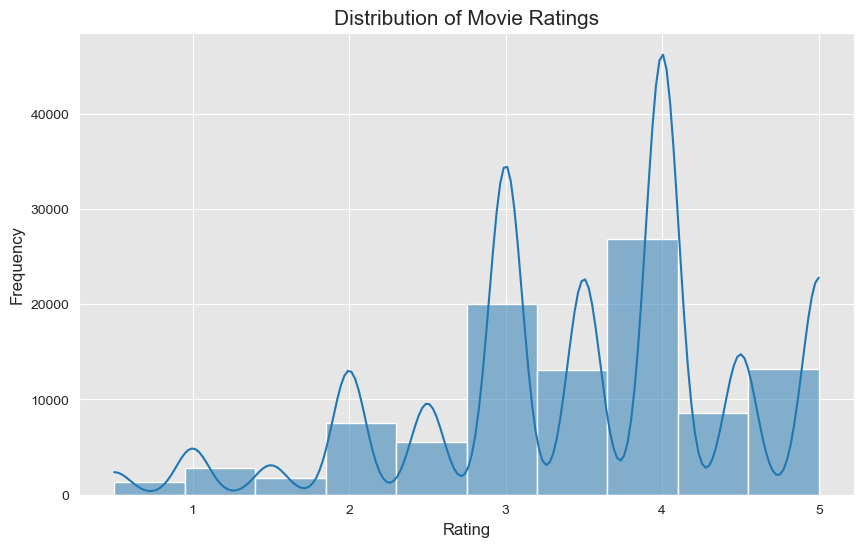

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Setting a style for the plots
sns.set_style('darkgrid', {'axes.facecolor':'0.9'})

# Plotting the distribution of ratings
plt.figure(figsize=(10,6))
sns.histplot(ratings_df['rating'], bins=10, kde=True)
plt.title('Distribution of Movie Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

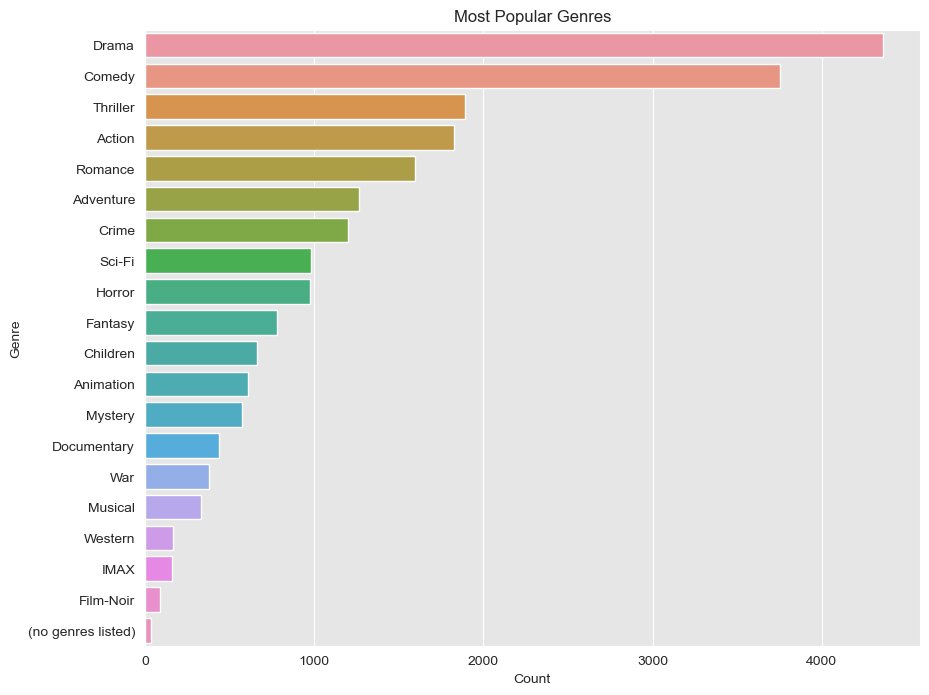

In [14]:
genres = (movies_df['genres'])

# Plot the most popular genres
plt.figure(figsize=(10, 8))
sns.countplot(y=genres, order=genres.value_counts().index)
plt.title('Most Popular Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

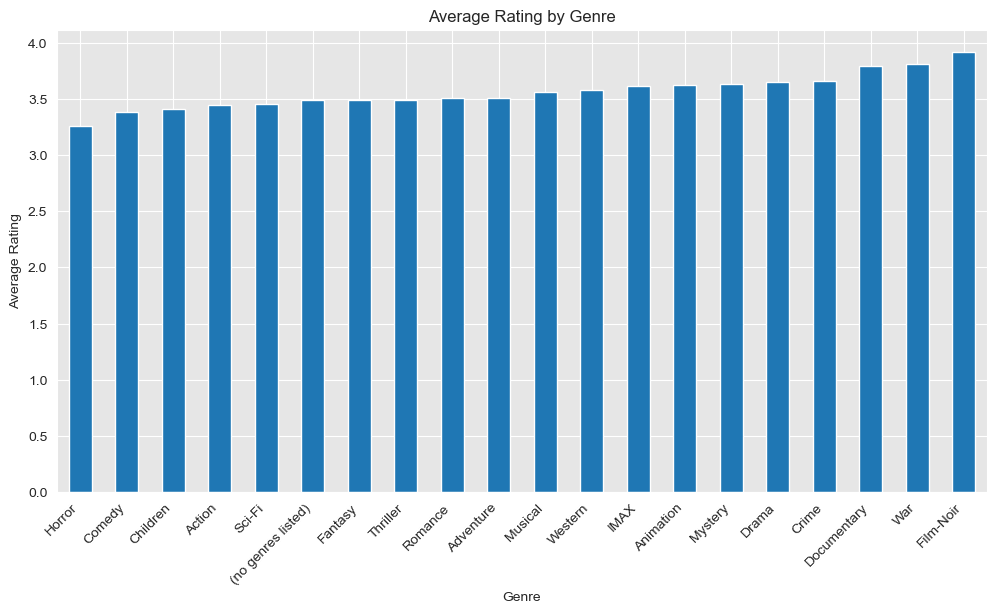

In [15]:
avg_genre_ratings = movies_df.merge(ratings_df, on='movieId').groupby('genres')['rating'].mean().sort_values()

plt.figure(figsize=(12, 6))
avg_genre_ratings.plot(kind='bar')
plt.title('Average Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.show()

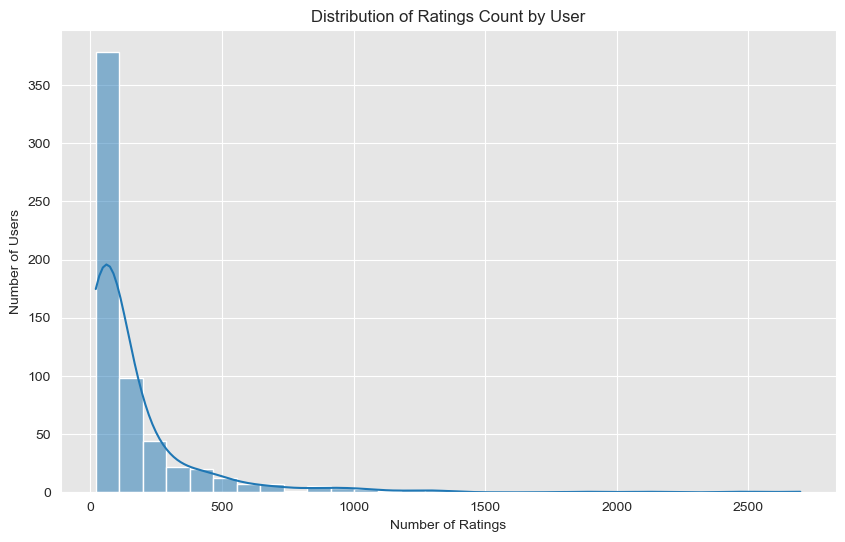

In [16]:
ratings_count_by_user = ratings_df['userId'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(ratings_count_by_user, bins=30, kde=True)
plt.title('Distribution of Ratings Count by User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

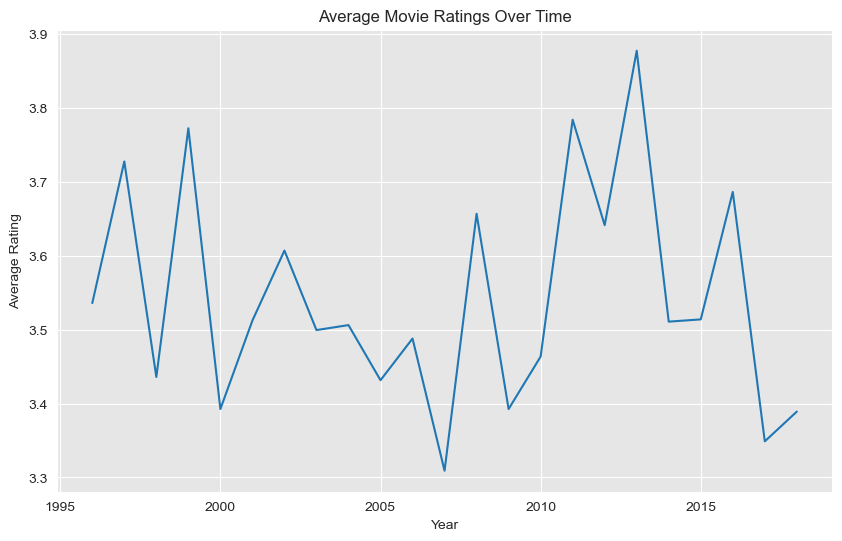

In [17]:
# Convert timestamp to datetime
yearly_ratings = ratings_df.groupby('year')['rating'].mean().reset_index()

# Line plot for average rating per year
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='rating', data=yearly_ratings)
plt.title('Average Movie Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

**5. Recommendation Systems Algorithms.**

- KNN algorithm

*a. User-based collaborative filtering*

In [18]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split   

Eradicate sparcity problem by increasing our data density.

In [19]:
# Limit user and movie ratings count to 10
min_user_ratings = 10
min_movie_ratings = 10 


user_ratings_count = movie_ratings_df['userId'].value_counts()
filtered_users = user_ratings_count[user_ratings_count >= min_user_ratings].index

movie_ratings_count = movie_ratings_df['movieId'].value_counts()
filtered_movies = movie_ratings_count[movie_ratings_count >= min_movie_ratings].index

filtered_ratings_df = movie_ratings_df[
    movie_ratings_df['userId'].isin(filtered_users) & 
    movie_ratings_df['movieId'].isin(filtered_movies)
]

filtered_ratings_df.shape

(253684, 11)

Create user-item matrix.

In [20]:
# Create the user-movie matrix
user_movie_matrix = filtered_ratings_df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
user_movie_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,182715,182823,183897,184471,185029,187031,187541,187593,187595,188301
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Train-test split

In [21]:
trainset, testset = train_test_split(user_movie_matrix.index, test_size=0.2, random_state=42)

Define a pipeline for the knn model.

In [22]:
# Define the pipeline steps
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors= 6)) 
])

pipeline_knn.fit(user_movie_matrix.loc[trainset])

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 NearestNeighbors(algorithm='brute', metric='cosine',
                                  n_neighbors=6))])

In [23]:
# K-nearest neighbors and their respective distances for users in test_matrix
distances, indices = pipeline_knn.named_steps['knn'].kneighbors(user_movie_matrix.loc[testset], n_neighbors= 6)

# Loop through each user index to display an organized output
for i, user_index in enumerate(testset):
    print(f"User ID {user_index}:")
    
    for neighbor_idx, distance in zip(indices[i][1:], distances[i][1:]):
        neighbor_user_id = user_movie_matrix.index[neighbor_idx]
        print(f"  Similar User: {neighbor_user_id}, Similarity Distance: {distance:.4f}")
    
    print()

User ID 82:
  Similar User: 423, Similarity Distance: 0.7670
  Similar User: 90, Similarity Distance: 0.8041
  Similar User: 190, Similarity Distance: 0.8086
  Similar User: 373, Similarity Distance: 0.8089
  Similar User: 20, Similarity Distance: 0.8148

User ID 219:
  Similar User: 423, Similarity Distance: 0.7167
  Similar User: 295, Similarity Distance: 0.7222
  Similar User: 100, Similarity Distance: 0.7284
  Similar User: 20, Similarity Distance: 0.7342
  Similar User: 164, Similarity Distance: 0.7377

User ID 56:
  Similar User: 358, Similarity Distance: 0.6118
  Similar User: 158, Similarity Distance: 0.6188
  Similar User: 33, Similarity Distance: 0.6303
  Similar User: 139, Similarity Distance: 0.6387
  Similar User: 147, Similarity Distance: 0.6499

User ID 599:
  Similar User: 190, Similarity Distance: 0.6385
  Similar User: 296, Similarity Distance: 0.6593
  Similar User: 423, Similarity Distance: 0.6725
  Similar User: 164, Similarity Distance: 0.6797
  Similar User: 447,

Model Evaluation

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Create empty lists to store true and predicted ratings
true_ratings = []
predicted_ratings = []

# Iterate over each user in the test set
for i, user_id in enumerate(testset):
    # Get similar users and distances for the current user excluding the user themselves
    similar_users_indices = indices[i][1:] 
    similar_users_distances = distances[i][1:]

    # Actual ratings of the current test user
    user_ratings = user_movie_matrix.loc[user_id]
    
    # Predict rating for each user
    for movie_id in user_ratings.index:
        if user_ratings[movie_id] > 0:
            # Ratings from similar users for this movie
            neighbor_ratings = []
            similarity_weights = []

            for j, neighbor_index in enumerate(similar_users_indices):
                neighbor_user_id = user_movie_matrix.index[neighbor_index]
                neighbor_rating = user_movie_matrix.loc[neighbor_user_id, movie_id]
                
                # Ratings from users who have rated the movie
                if neighbor_rating > 0:
                    neighbor_ratings.append(neighbor_rating)
                    similarity_weights.append(1 - similar_users_distances[j])
            
            # Predict the rating if there are any neighbors with ratings
            if neighbor_ratings:
                weighted_average = np.average(neighbor_ratings, weights=similarity_weights)
            else:
                weighted_average = user_movie_matrix.mean().mean()
            
            # Append to true and predicted lists
            true_ratings.append(user_ratings[movie_id])
            predicted_ratings.append(weighted_average)


rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
mae = mean_absolute_error(true_ratings, predicted_ratings)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 2.8524
MAE: 2.4488


*b. Item-based collaborative filtering*

In [29]:
 #Split data into training and test sets
train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=42)

# Create item-user interaction matrices (movies as rows, users as columns)
train_movie_user_matrix = train_data.pivot(index='movieId', columns='userId', values='rating').fillna(0)
test_movie_user_matrix = test_data.pivot(index='movieId', columns='userId', values='rating').fillna(0)

# Align matrices to ensure the same users in both train and test
train_movie_user_matrix, test_movie_user_matrix = train_movie_user_matrix.align(test_movie_user_matrix, join='outer', axis=1, fill_value=0)

# Define the pipeline steps
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors= 6)) 
])

pipeline_knn.fit(train_movie_user_matrix.values)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 NearestNeighbors(algorithm='brute', metric='cosine',
                                  n_neighbors=6))])

In [33]:
def predict_ratings_item_based(train_matrix, knn_model, test_data):
    predictions = []
    for _, row in test_data.iterrows():
        user_id, movie_id = row['userId'], row['movieId']
        
        if movie_id in train_matrix.index:
            # Find similar movies
            _, indices = knn_model.named_steps['knn'].kneighbors(train_matrix.loc[movie_id].values.reshape(1, -1), n_neighbors=6)
            
            # Check if the user_id exists in the train_matrix columns
            if user_id in train_matrix.columns:
                # Get ratings from the user for similar movies
                similar_movies_ratings = train_matrix.iloc[indices.flatten(), train_matrix.columns.get_loc(user_id)]
                
                # Predict rating as the mean of similar movie ratings (excluding zeros)
                non_zero_ratings = similar_movies_ratings[similar_movies_ratings > 0]
                predictions.append(non_zero_ratings.mean() if len(non_zero_ratings) > 0 else 0)
            else:
                # If user_id not in train_matrix columns, assign default rating
                predictions.append(0)
        else:
            predictions.append(0)  # Default rating for unknown movies
    return predictions

In [ ]:
distances, indices = pipeline_knn.named_steps['knn'].kneighbors(user_movie_matrix.loc[testset], n_neighbors= 6)

In [34]:
# Call the prediction function
predicted_ratings = predict_ratings_item_based(train_movie_user_matrix, pipeline_knn, test_data)
print(predicted_ratings)

[0, 2.875, 2.375, 4.0, 0, 3.0, 4.0, 0, 3.0, 4.5, 0, 0, 3.125, 2.5, 4.0, 0, 0, 0, 3.75, 0, 3.375, 0, 3.75, 4.0, 4.0, 2.5, 0, 3.0, 4.0, 0, 3.5, 0, 2.5, 3.0, 0, 0, 2.5, 3.75, 3.3, 0, 0, 0, 4.666666666666667, 0, 5.0, 0, 0, 3.5, 0, 1.0, 4.5, 4.0, 3.0, 0, 3.0, 3.5, 0, 0, 4.5, 2.5, 5.0, 0, 0, 3.0, 2.5, 5.0, 0, 4.0, 4.0, 0, 0, 0, 0, 4.25, 0, 0, 0, 0, 0, 0, 3.5, 0, 0, 1.0, 3.75, 2.0, 0, 4.5, 2.5, 4.5, 0, 0, 3.0, 0, 4.0, 0, 3.25, 4.0, 4.5, 0, 0, 2.8333333333333335, 0, 0, 4.0, 0, 3.0, 0, 5.0, 2.0, 3.1666666666666665, 4.0, 0, 4.0, 3.1666666666666665, 3.9, 0, 4.0, 0, 3.0, 0, 0, 0, 2.5, 0, 4.5, 3.75, 4.0, 3.2, 0, 4.666666666666667, 3.5, 5.0, 0, 4.6, 4.0, 2.6666666666666665, 0, 0, 0, 0, 0, 0, 4.25, 0, 2.75, 0, 0, 4.0, 4.5, 5.0, 3.0, 4.25, 3.0, 0, 0, 0, 0, 0, 3.0, 3.3333333333333335, 3.75, 0, 3.25, 3.0, 0, 0, 5.0, 0, 4.5, 0, 0, 3.0, 4.0, 0, 0, 0, 4.0, 0, 1.0, 4.4, 4.5, 0, 0, 0, 4.5, 2.0, 3.0, 0, 4.5, 0, 3.75, 0, 0, 0, 0, 0, 0, 0, 4.0, 0, 4.25, 4.4, 3.5, 0, 4.0, 3.8333333333333335, 3.0, 0, 4.0, 3.0, 0,

Model evaluation

In [35]:
# Evaluate predictions
actual_ratings = test_data['rating']
mae = mean_absolute_error(actual_ratings, predicted_ratings)
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))

print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')

MAE: 1.9120, RMSE: 2.4973


- Model-based algorithm

In [36]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split


# Load data into Surprise format
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(movie_ratings_df[['userId', 'movieId', 'rating']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.25)

# Use Singular Value Decomposition (SVD) for model-based collaborative filtering
algo = SVD()
algo.fit(trainset)

# Predict ratings
predictions = algo.test(testset)

# Evaluate model accuracy
accuracy.rmse(predictions)

RMSE: 0.5313


0.5312649097238904

In [37]:
predictions_df = pd.DataFrame(predictions, columns= ['user_id', 'item_id', 'true_rating', 'estimated_rating', 'details'])
predictions_df.head(10)

,user_id,item_id,true_rating,estimated_rating,details
0,425,1617,3.5,3.636869,{'was_impossible': False}
1,469,2455,3.0,2.615671,{'was_impossible': False}
2,380,5378,3.0,2.988822,{'was_impossible': False}
3,274,27674,4.0,3.786807,{'was_impossible': False}
4,552,594,4.0,3.772365,{'was_impossible': False}
5,586,86880,5.0,4.648986,{'was_impossible': False}
6,599,27722,3.5,3.356106,{'was_impossible': False}
7,446,648,4.0,3.240585,{'was_impossible': False}
8,493,1527,3.0,3.317511,{'was_impossible': False}
9,307,1307,3.5,3.007639,{'was_impossible': False}


In [38]:
user_ids = movie_ratings_df['userId'].unique()
movie_ids = movie_ratings_df['movieId'].unique()

# Number of reccomendations to make
N = 5
recommendations = {}

# Loop over each user
for user_id in user_ids:
    rated_movie_ids = movie_ratings_df[movie_ratings_df['userId'] == user_id]['movieId'].unique()

    unrated_movie_ids = [m_id for m_id in movie_ids if m_id not in rated_movie_ids]

    # Predict ratings for the unrated movies
    predictions = [algo.predict(user_id, m_id) for m_id in unrated_movie_ids]

    # Sort predictions by estimated rating (highest first)
    predictions.sort(key=lambda x: x.est, reverse=True)

    top_n_recommendations = predictions[:N]

    # Store the recommendations for each user
    recommendations[user_id] = [(pred.iid, pred.est) for pred in top_n_recommendations]

In [39]:
# Display top 5 recommendations for all users
for user_id, recs in recommendations.items():
    print(f'\nTop {N} recommendations for User {user_id}:')
    for movie_id, predicted_rating in recs:
        print(f'Movie ID: {movie_id}, Predicted Rating: {predicted_rating:.2f}')


Top 5 recommendations for User 1:
Movie ID: 318, Predicted Rating: 5.00
Movie ID: 32, Predicted Rating: 5.00
Movie ID: 58, Predicted Rating: 5.00
Movie ID: 162, Predicted Rating: 5.00
Movie ID: 265, Predicted Rating: 5.00

Top 5 recommendations for User 2:
Movie ID: 922, Predicted Rating: 4.50
Movie ID: 3266, Predicted Rating: 4.50
Movie ID: 1213, Predicted Rating: 4.48
Movie ID: 953, Predicted Rating: 4.46
Movie ID: 1284, Predicted Rating: 4.41

Top 5 recommendations for User 3:
Movie ID: 1129, Predicted Rating: 4.68
Movie ID: 56367, Predicted Rating: 4.65
Movie ID: 3535, Predicted Rating: 4.39
Movie ID: 1179, Predicted Rating: 4.37
Movie ID: 610, Predicted Rating: 4.16

Top 5 recommendations for User 4:
Movie ID: 1212, Predicted Rating: 4.93
Movie ID: 1220, Predicted Rating: 4.92
Movie ID: 91529, Predicted Rating: 4.90
Movie ID: 923, Predicted Rating: 4.86
Movie ID: 7438, Predicted Rating: 4.84

Top 5 recommendations for User 5:
Movie ID: 4306, Predicted Rating: 4.86
Movie ID: 8949,

In [40]:
predictions_df = pd.DataFrame(predictions, columns= ['user_id', 'item_id', 'true_rating', 'estimated_rating', 'details'])
predictions_df.head()

,user_id,item_id,true_rating,estimated_rating,details
0,610,1220,None,4.935106,{'was_impossible': False}
1,610,3508,None,4.813383,{'was_impossible': False}
2,610,2700,None,4.769100,{'was_impossible': False}
3,610,1219,None,4.764210,{'was_impossible': False}
4,610,27156,None,4.740059,{'was_impossible': False}


- Content based algorithm

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Using TF-IDF to compute similarity based on movie genres
movies_df['genres'] = movies_df['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Vectorize genres
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])

# Compute similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to get movie recommendations based on similarity score
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = movies_df[movies_df['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get top 10
    movie_indices = [i[0] for i in sim_scores]
    return movies_df['title'].iloc[movie_indices]

# Get recommendations for a specific movie
recommendations = get_recommendations('Toy Story (1995)')
print(recommendations)

1                                        Jumanji (1995)
7                                   Tom and Huck (1995)
9                                      GoldenEye (1995)
12                                         Balto (1995)
14                              Cutthroat Island (1995)
28    City of Lost Children, The (Cité des enfants p...
40                                 Mortal Kombat (1995)
48                                      Lamerica (1994)
53                   Indian in the Cupboard, The (1995)
77                                  White Squall (1996)
Name: title, dtype: object


- Hybrid algorithm

In [42]:
# Assume you have a user and movie to recommend for
user_id = 1
movie_title = 'Toy Story (1995)'
movie_idx = movies_df[movies_df['title'] == movie_title].index[0]

# Get content-based recommendations for a given movie
content_recs = get_recommendations(movie_title)

# Predict rating using collaborative filtering
movie_id = movies_df.loc[movie_idx, 'movieId']
collab_pred = algo.predict(user_id, movie_id).est

# Assume we assign a weight to each component
collab_weight = 0.7
content_weight = 0.3

# Hybrid score: weighted average of collaborative and content-based score
# For simplicity, using 5.0 as the max score in content-based ranking
content_sim_score = cosine_sim[movie_idx].mean() * 5.0
hybrid_score = collab_weight * collab_pred + content_weight * content_sim_score

print(f'Collaborative score: {collab_pred}')
print(f'Content-based similarity score: {content_sim_score}')
print(f'Hybrid score: {hybrid_score}')

TypeError: unhashable type: 'Series'

In [ ]:
collab_rmse = accuracy.rmse(collab_predictions)